# Navigation

---
Train an Agent on Unity ML-Agents environment to navigate and collect as many yellow bananas as possible.

In [1]:
# import required packages
import torch
import numpy as np
from unityagents import UnityEnvironment

In [2]:
seed    = 42   # initialize the seed to get similar outcomes
# device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # initialize the device
# print("Device: {}".format(device))
device = "cpu"

In [3]:
# setup the environment by providing the path to the env file
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64", seed=seed)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
# brains are responsible for deciding the actions of their associated agents
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# examine the state and action spaces
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents in the environment
print('Number of agents:', len(env_info.agents))
# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.78926337 0.
 1.         0.         0.         0.55464244 0.         1.
 0.         0.         0.42521358 0.         1.         0.
 0.         0.56680632 0.         1.         0.         0.
 0.46538338 0.         1.         0.         0.         0.51788217
 0.         0.         1.         0.         0.39806581 0.
 0.        ]
States have length: 37


### Train the agent

In [6]:
# import required torch libraries
from torch import nn

class DQNetwork(nn.Module):
    """ A Deep-Q-Network model. """
    def __init__(self, state_size, action_size, seed):
        """ Initialize parameters and build model. 
        Parameters
        ----------
            state_size (int):   Dimension of each state
            action_size (int):  Dimension of each action
            seed(int):          Random seed
        """
        super(DQNetwork, self).__init__()
        self.seed   = torch.manual_seed(seed)

        # Define the fully connected layers
        self.fc1    = nn.Linear(state_size, 128)
        self.relu1  = nn.ReLU()
        self.bn1    = nn.BatchNorm1d(128)
        self.do1    = nn.Dropout(0.1)

        self.fc2    = nn.Linear(128, 64)
        self.relu2  = nn.ReLU()
        self.bn2    = nn.BatchNorm1d(64)
        self.do2    = nn.Dropout(0.1)

        self.fc3    = nn.Linear(64, 32)
        self.relu3  = nn.ReLU()
        self.bn3    = nn.BatchNorm1d(32)
        self.do3    = nn.Dropout(0.1)

        self.out    = nn.Linear(32, action_size)
    
    def forward(self, state):
        x = self.do1(self.bn1(self.relu1(self.fc1(state))))
        x = self.do2(self.bn2(self.relu2(self.fc2(x))))
        x = self.do3(self.bn3(self.relu3(self.fc3(x))))
        return self.out(x)

In [7]:
import random
from collections import namedtuple, deque

class ReplayBuffer:
    """ Fixed-size buffer to store experience tuples. """
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """ Initialize Replay buffer
        Parameters
        ----------
            action_size (int):  Dimension of each action
            buffer_size (int):  Maximum size of buffer
            batch_size (int):   Size of each training batch
            seed (int):         Random seed
        """
        self.action_size    = action_size
        self.memory         = deque(maxlen=buffer_size)
        self.batch_size     = batch_size
        self.experience     = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed           = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """ Add a new experience to memory. """
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """ Select Random samples of batch size"""

        experiences = random.sample(self.memory, k=self.batch_size)
        states      = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions     = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards     = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones       = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """ Return the current size of internal memory. """
        return len(self.memory)

In [8]:
import random
import torch.optim as optim
import torch.nn.functional as F

class Agent():
    """ An agent interacts with environment and learns from it. """
    def __init__(self, state_size, action_size, seed):
        """ Initialize the agent """
        self.state_size     = state_size
        self.action_size    = action_size
        self.seed           = random.seed(seed)

        # Hyper parameters
        self.lr             = 5e-4      # learning rate
        self.gamma          = 0.99      # discount factor
        self.batch_size     = 64        # minibatch size for training
        self.tau            = 1e-3      # soft update weight for target params
        self.buffer_size    = int(1e7)  # replay buffer size
        self.local_update_freq    = 4   # how often to update the local network
        self.target_update_freq   = self.local_update_freq * 4 # how often to update target network
        
        # DQ-Network
        self.q_network_local    = DQNetwork(self.state_size, self.action_size, seed)
        self.q_network_target   = DQNetwork(self.state_size, self.action_size, seed)
        self.optimizer          = optim.Adam(self.q_network_local.parameters(), lr=self.lr, weight_decay=1e-5)
        
        # Replay memory
        self.memory     = ReplayBuffer(self.action_size, self.buffer_size, self.batch_size, seed)
        # Initialize time step (for updating every "update_freq" steps)
        self.t_step_local   = 0
        self.t_step_target  = 0
        
    def act(self, state, eps=0.0):
        """ Returns action for given state as per current policy.
        Parameters
        ----------
            state (array_like): Current_state
            eps (float):        Epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(np.array(state.tolist())).float().unsqueeze(0).to(device)
        
        # Set the network to evaluation mode
        self.q_network_local.eval()
        with torch.no_grad():
            action_values = self.q_network_local(state)

        # Set the network back to training mode
        self.q_network_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def soft_update(self, local_model, target_model, tau: float):
        """ Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Parameters
        ----------
            local_model (PyTorch model):    weights will be copied from
            target_model (PyTorch model):   weights will be copied to
            tau (float):                    interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)
                
    def learn(self, experiences, gamma):
        """ Update value parameters using given batch of experience tuples. 
        Parameters
        ----------
            experiences (Tuple[torch.Variable]):    tuple of (s, a, r, s', done) tuples
            gamma (float):                          discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.q_network_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        # if done add only reward, if not add the discounted expected value
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Get expected Q values from local model
        Q_expected = self.q_network_local(states).gather(1, actions)
    
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------ Update the target network -------------------#
        if (self.t_step_target == 0):
            self.soft_update(self.q_network_local, self.q_network_target, self.tau)

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every "update_freq" steps
        self.t_step_local = (self.t_step_local + 1) % self.local_update_freq
        self.t_step_target = (self.t_step_target + 1) % self.target_update_freq
        
        if (self.t_step_local == 0):
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

In [9]:
agent = Agent(state_size, action_size, seed)

In [10]:
def dqn(num_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """ Deep Q-Learning.
    Parameters
    ----------
        n_episodes (int):   Maximum number of training episodes
        max_t (int):        Maximum number of timesteps per episode
        eps_start (float):  Starting value of epsilon, for epsilon-greedy policy
        eps_end (float):    Minimum value of epsilon
        eps_decay (float):  Decay rate of epsilon over the time
    """
    scores = []
    scores_window = deque(maxlen=100)
    eps     = eps_start

    for i_episode in range(1, num_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment
        state = env_info.vector_observations[0]                 # get the current state
        score = 0                                               # initialize the score
        for t in range(max_t):
            action = agent.act(state)                           # select an action
            env_info = env.step(action)[brain_name]             # send the action to the environment
            next_state = env_info.vector_observations[0]        # get the next state
            reward = env_info.rewards[0]                        # get the reward
            done = env_info.local_done[0]                       # see if episode has finished
            agent.step(state, action, reward, next_state, done) # step for the agent to learn from the outcome
            score += reward                                     # update the score
            state = next_state                                  # roll over the state to next time step
            if done:                                            # exit loop if episode finished
                break
        scores.append(score)
        scores_window.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window))) 
    return scores

In [11]:
scores = dqn()

Episode 100	Average Score: 0.62
Episode 200	Average Score: 1.63
Episode 300	Average Score: 5.74
Episode 400	Average Score: 4.92
Episode 500	Average Score: 5.24
Episode 600	Average Score: 8.24
Episode 700	Average Score: 8.86
Episode 800	Average Score: 11.93
Episode 900	Average Score: 14.01
Episode 1000	Average Score: 14.57
Episode 1100	Average Score: 15.50
Episode 1200	Average Score: 16.64
Episode 1300	Average Score: 16.44
Episode 1400	Average Score: 17.10
Episode 1500	Average Score: 16.46
Episode 1600	Average Score: 16.99
Episode 1700	Average Score: 16.95
Episode 1800	Average Score: 16.92
Episode 1900	Average Score: 17.65
Episode 2000	Average Score: 17.09


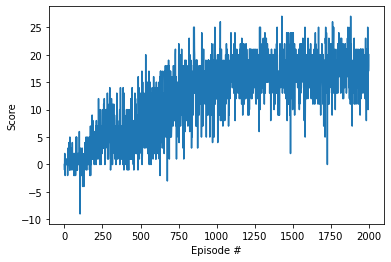

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [16]:
# torch.save(agent.q_network_local.state_dict(), 'model.pt')

In [17]:
# load the weights from file
agent.q_network_local.load_state_dict(torch.load('model.pt'))

In [19]:
# Watch the trained agent navigating and doing its task
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 21.0
